# Regularization and Nonlinear Regression
G. Richards
(2016,2018,2020)
based on materials from Connolly (especially) and Ivezic Chapter 8.3, 8.5-8.7, 8.9, 8.10

## Regularization

We have to be a little careful when doing regression because if we progressively increase the complexity of the model, then we reach a regime where we are overfitting the data (i.e. there are too many degrees of freedom in the model).

For example, let's look at an example using Polynomial Regression. 

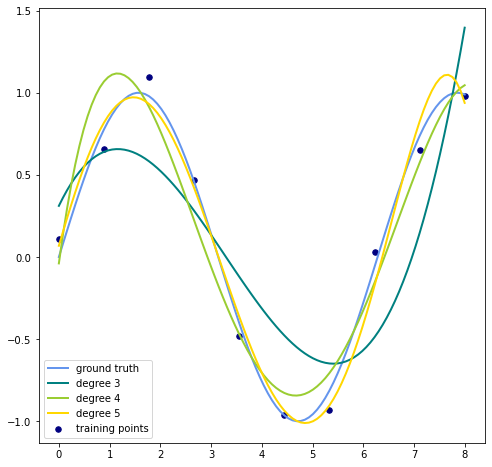

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astroML.linear_model import PolynomialRegression

orders=[3,4,5]

def f(x):
    """ function to approximate by polynomial interpolation"""
    return np.sin(x)

# generate points used to plot
x_plot = np.linspace(0, 8, 100)

# generate points and keep a subset of them
x = np.linspace(0, 8, 10)
#rng = np.random.RandomState(0)
#rng.shuffle(x)
#x = np.sort(x[:10])
y = f(x)+0.25*(np.random.random(len(x))-0.5)

# create matrix versions of these arrays
X = x[:, None]
X_plot = x_plot[:, None]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.figure(figsize=(8,8))
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw, label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate(orders):
    poly = PolynomialRegression(degree)
    poly.fit(X,y)
    y_plot = poly.predict(X_plot)

    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

This is fit with order = 3, 4, and 5.  What happens if you make the order $\sim N_{\rm points}$?  Try it.

In that case we are clearly overfitting the data.  For cases where we are concerned with overfitting, instead of computing 

$$(Y - M \theta)^T(Y- M \theta),$$

we can apply constraints (usually of smoothness, number of coefficients, size of coefficients):

$$(Y - M \theta)^T(Y- M \theta) + \lambda |\theta^T \theta|^2,$$

with $\lambda$ as the "regularization parameter".

This leads to a solution for the parameters of the model

$$\theta = (M^T C^{-1} M + \lambda I)^{-1} (M^T C^{-1} Y)$$

with $I$ the identity matrix.

From the Bayesian perspective this is the same as applying a prior like:

$$p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)^2}{2}\right)}$$

which, when multiplied by the likelihood for regression, gives the same answer for the maximum likelihood of the posterior probability as described above.

## Ridge regression 

The case for such a Gaussian prior corresponds to [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), which
penalizes the regression coefficients according to

$$ |\theta |^2 < s.$$

That is the square of each parameter in the fitting is restricted to be less than some value, $s$.  We'll come back to exactly what $s$ is in a minute.  Doing this supresses large coefficients and limits the variance of the system---at the cost of increased bias.

The following figure illustrates the interaction of the prior and the posterior without the prior:
![Ivezic, Figure 8.3](http://www.astroml.org/_images/fig_lasso_ridge_1.png)

Scikit-Learn's [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is their implementation of ridge regression, while AstroML implements Ridge Regression as follows:

In [4]:
import numpy as np
from sklearn.linear_model import Ridge
X = np.random.random((100,10))
y = np.dot(X, np.random.random(10))
model = Ridge(alpha=0.05) #alpha here is lambda in the book
model.fit(X,y)
y_pred = model.predict(X)

The following example compares Gaussian Basis Regression with and without the constraints from Ridge Regression.  It uses 100 evenly spaced Gauassians, which we can see strongly overfits the problem and has very large coefficient values, until a constraint is imposed.

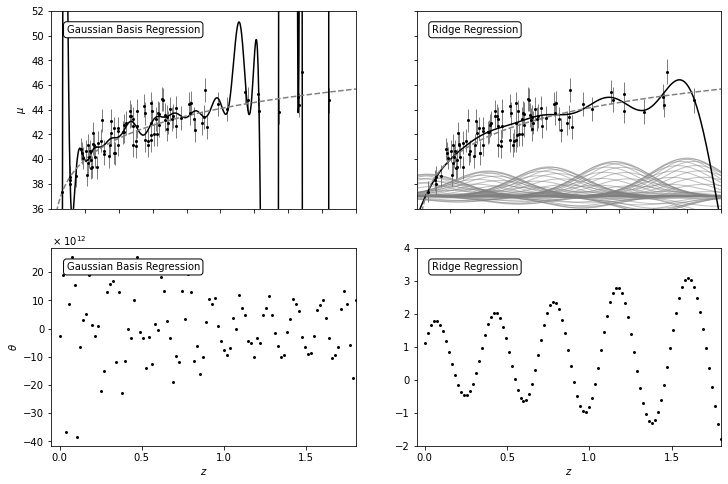

In [5]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge

#from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# generate data
np.random.seed(0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu = cosmo.distmod(z)

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, None], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 8))

classifier = [LinearRegression, Ridge]
kwargs = [dict(), dict(alpha=0.005)]
labels = ['Gaussian Basis Regression', 'Ridge Regression']

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

## Least absolute shrinkage and selection (LASSO) regularization

An alternative to Ridge Regression is LASSO, which implies the following contraint

$$(Y - M \theta)^T(Y- M \theta) + \lambda |\theta|.$$

This is equivalent to least-squares minimization with 
$$ |\theta | < s,$$
that is, the penalty is on the absolute values of the regression coefficients, which is also illustrated in Ivezic, Figure 8.3 as shown above.

It not only weights the regression coefficients, it also imposes sparsity on the regression
model (i.e. the penalty preferentially selects regions of likelihood space that coincide with one of the vertices within the region defined by the regularization).

This has the effect of setting one (or more) of the model attributes to zero.  

[Scikit-Learn's `LASSO`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is implemented as follows:

In [6]:
import numpy as np
from sklearn.linear_model import Lasso
XX = np.random.random((100,10))
yy = np.dot(XX, np.random.random(10))
model = Lasso(alpha = 0.05)
model.fit(XX,yy)
y_pred = model.predict(XX)

Below I have copied the Ridge regression cell from above.  Modify the three lines of code needed to replace Ridge regression with Lasso regression.  Then experiment with different values of the regularization parameter.

N.B.  $\lambda$ in the book is related to $\alpha$ in these examples.

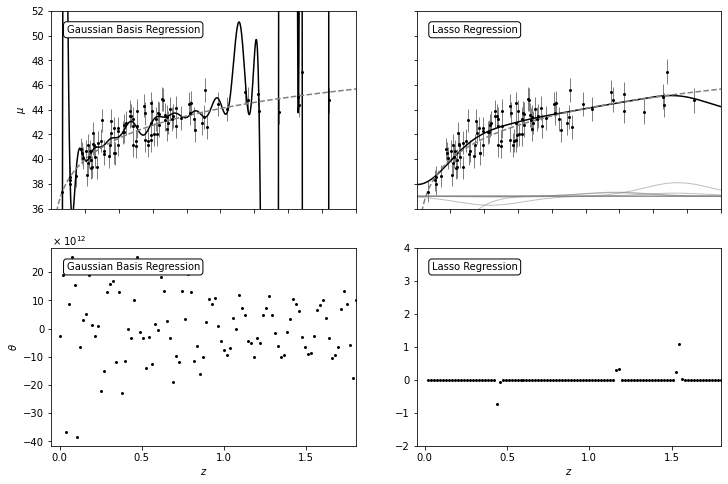

In [13]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso ####

#from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# generate data
np.random.seed(0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu = cosmo.distmod(z)

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, None], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 8))

# classifier = [LinearRegression, Ridge] ####
# kwargs = [dict(), dict(alpha=0.005)] ####
# labels = ['Gaussian Basis Regression', 'Ridge Regression'] ####

classifier = [LinearRegression, Lasso]
kwargs = [dict(), dict(alpha=0.005)]
labels = ['Gaussian Basis Regression', 'Lasso Regression']

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5) 

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

Did you try `alpha=0`?  If not, go ahead and do that.  

Are you totally confused?  Don't worry, it is much simpler than it seems.  I found [Hastie](http://statweb.stanford.edu/~tibs/ElemStatLearn/index.html) to be helpful in sorting this out. 

They write the constraint term as 
$$\lambda \sum_{j=1}^p |\theta_j|^q,$$
which allows us to see that Ridge regression corresponds to $q=2$, while LASSO regression corresponds to $q=1$.  So, they are really the same thing: Bayes estimates with different priors.   The wildly different names are just a nuisance.

With that in mind, now let's see if we can understand what is going on in Ivezic, Figure 8.3.  We now have

$$ |\theta |^q < s.$$

Think of $s$ as a normalized distance where $s=1$ corresponds to there being no constraint on $\theta_i$.  Requiring $s<1$ limits the magnitude of $\theta_i$.  So, in this figure
![Ivezic, Figure 8.3](http://www.astroml.org/_images/fig_lasso_ridge_1.png)
$s=1$ would make the circle/diamond big enough to include what they call $\theta_{\rm normal}$.  

It isn't obvious to me, but I guess that the $\theta_i$ are normalized such that the contraint region is symmetric.  

Shrinking $s$ has the effect of adding a prior that moves the best-fit parameters to the intersection of the two sets of contours.  The difference between Ridge and LASSO is just the shape of the constraint region.  For LASSO, the shape is such that some of the parameters may end up being 0.  

Figures 3.8 (page 84 of the [Hastie PDF](http://statweb.stanford.edu/~tibs/ElemStatLearn/index.html)), 3.10 (page 89), and 3.12 (page 91) may be helpful.

### How do we choose $\lambda$?

Use cross-validation as discussed last time.  

Let's practice using the [Boston Housing data](http://scikit-learn.org/stable/datasets/index.html#boston-house-prices-dataset).  

As a reminder, this data set contains 12 attributes that can be used to predict the price of houses in Boston.  Because the attributes (columns of $X$) are inhomogenous, some may be more relevant than others.  So LASSO might be a good thing to try in such situations.

In [10]:
#Execute this cell to read in the data
#Also identify the index of the "Number of Rooms" attribute
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Start by looking at just how the number of rooms predicts the price.

In [11]:
RMindex = np.argwhere(boston.feature_names=="RM")[0,0]
print(RMindex)

X_RM = boston.data[:,RMindex][:,None]
y = boston.target

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_RM, y)
print(reg.coef_, reg.intercept_)

5
[9.10210898] -34.67062077643857


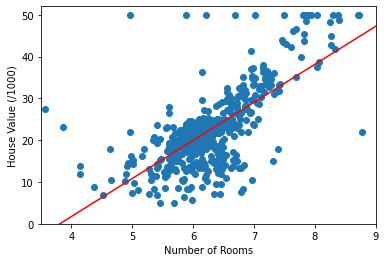

In [12]:
import matplotlib.pyplot as plt
plt.scatter(X_RM,y)
plt.xlabel("Number of Rooms")
plt.ylabel("House Value (/1000)")

Xgrid = np.linspace(1,9,9)
ypred = reg.intercept_ + Xgrid*reg.coef_[0]
plt.plot(Xgrid,ypred,c='r')
plt.xlim(3.5,9)
plt.ylim(0,52)
plt.show()

Now use all attributes, first with `LinearRegression`.  Then with LinearRegression again, but with the data scaled using `StandardScaler` from `sklearn.preprocessing` (since the features are very heterogeneous).  Then fit the scaled data agin with LASSO to see which features aren't that important.  We'll plot the coefficients of each.

In [14]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = boston.data
y = boston.target

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

linreg = LinearRegression().fit(X,y)
linreg_scaled = LinearRegression().fit(Xscaled,y)
lasso_scaled = Lasso(alpha=0.005).fit(Xscaled,y)

print(linreg.coef_, linreg.intercept_)
print(linreg_scaled.coef_, linreg_scaled.intercept_)
print(lasso_scaled.coef_, lasso_scaled.intercept_)

[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01] 36.459488385089855
[-0.92814606  1.08156863  0.1409      0.68173972 -2.05671827  2.67423017
  0.01946607 -3.10404426  2.66221764 -2.07678168 -2.06060666  0.84926842
 -3.74362713] 22.532806324110684
[-0.91415424  1.05773032  0.09382951  0.68324563 -2.01554749  2.68236636
  0.         -3.08440865  2.57073189 -1.98746399 -2.04902428  0.84489637
 -3.73400793] 22.532806324110684


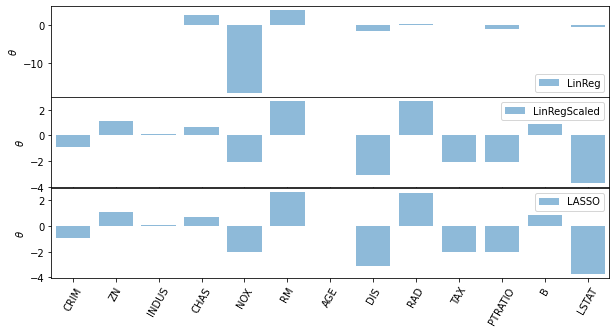

In [15]:
fig, ax = plt.subplots(figsize=(10, 5)) 
plt.subplots_adjust(hspace=0.001)

x_pos = np.arange(len(boston.feature_names))

for i in range(3):
    # plot theta
    ax = plt.subplot(311 + i)
    ax.set_ylabel(r'$\theta$')

    ax.set_xticks(x_pos)
    if i == 2:
        ax.set_xticklabels(boston.feature_names, rotation=60)     
    else: 
        ax.set_xticklabels([])
    
    ax.set_xlim(-0.5, 12.5)
 
    if i == 0:
        ax.bar(x_pos, linreg.coef_, alpha=0.5, label="LinReg")
        #ax.set_ylim(-2, 4)
        plt.legend(loc=4)
    elif i == 1:
        ax.bar(x_pos, linreg_scaled.coef_, alpha=0.5, label="LinRegScaled")
        #ax.set_ylim(-2, 4)
        plt.legend(loc=1)
    elif i == 2:
        ax.bar(x_pos, lasso_scaled.coef_, alpha=0.5, label="LASSO")
        #ax.set_ylim(-0.5, 2)
        plt.legend()

Note that NOX had a large coefficient (because it is factor of 10 smaller than RM), but isn't particularly relevant.  So, should probably scale the data first.

---

Up to now we have been fitting using *linear* models.  Before moving on to *non-linear* models, we'll look at local linear fitting.  Kernel Regression (or Nadaraya-Watson) was one such method.  

## Locally Linear Regression (LOWESS or LOESS)

In [Local Linear Regression](https://en.wikipedia.org/wiki/Local_regression) we assume that the regression function at any point can
be approximated by a [Taylor series expansion](https://www.mathsisfun.com/algebra/taylor-series.html).  If we truncated the Taylor series at the first term, then this would be the same as Nadaraya-Watson.

This is similar to Kernel regression, except that we fit the local regression to the weighted points by finding a $w(x)$ that minimizes

$$\sum_{i=1}^N  K\left(\frac{||x-x_i||}{h}\right) \left( y_i - w(x) \, x_i \right)^2.$$

One version of this called LOWESS (locally weighted scatter plot smoothing) uses the "tricubic" Kernel:

$$K(x_i,x) = \left ( 1 - \left ( \frac{|x - x_i |}h{}\right )^3 \right )^3.$$

However, the book isn't really very clear on this (or LOESS, which might stand for LOcal regrESSion) and it doesn't appear that this is implemented in either astroML or Scikit-Learn.  So, we are going to move on--just realize that there algorithms that are intermediate between linear and nonlinear.


## Non-linear Regression

Often we can make our non-linear data linear (e.g., if your $y$ values increase exponentially with $x$, by taking the log), but that has its own set of complications (e.g., asymmetric error bars).  So we should also consider non-linear regression.

If we know the theoretical form of the model, then one option is to use MCMC techniques to sample the parameter space and find the optimal model parameters.

An alternate approach is to use the Levenberg-Marquardt (LM) algorithm to optimize the maximum likelihood estimation. [Numerical Recipes](http://numerical.recipes/) is an excellent resource for more information about LM.  I can't really emphasize enough how ubiquitous LM is, you really should learn how it works in detail.

For now let's leave it as these few words of explanation (with links for further study).
LM searches through a combination of [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) and [Gauss-Newton](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) optimization. If we can express our
regression function as a Taylor series expansion then, to first order,
then we can write

$$f(x_i|\theta) = f(x_i|\theta_0) + J d\theta.$$

Here $\theta_0$ is an initial guess for the regression parameters,
$J$ is the Jacobian about this point ($J=\partial f(x_i|\theta)/ \partial
 \theta$), and $d\theta$ is a perturbation in the regression
parameters. 

LM minimizes the sum of square errors,

$$\sum_i [y_i- f(x_i|\theta_0) - J_i d\theta]^2,$$

for a perturbation $d\theta$. This minimization results in an update relation for
$d\theta$ given by

$$(J^TC^{-1}J + \lambda\ {\rm diag}(J^TC^{-1}J) )\,d\theta = J^TC^{-1}(Y-f(X|\theta)),$$

where $\lambda$ term acts as a damping parameter.  If $\lambda$ is small, then the relation approximates a Gauss-Newton method (i.e., it minimizes the parameters assuming the function is quadratic). If $\lambda$ is large the perturbation $d\theta$ follows the direction of
steepest descent. The diag$(J^TC^{-1}J)$ term is what makes it different from Ridge Regression and it ensures that the update of $d\theta$ is largest along directions where the gradient is smallest (which
improves convergence).

This is an iterative process which ceases when the change in likelihood values reaches a predetermined limit.

Don't worry if that doesn't make any sense.  We are going to talk about gradient descent again when we get to artificial neural networks.

In SciPy [`scipy.optimize.leastsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html) implements the LM algorithm.
Here is an example call to estimate the first 6 terms of the Taylor series for $y=\sin x$.

In [16]:
import numpy as np
from scipy import optimize
x = np.linspace(-3,3,100) # 100 values between -3 and 3

def taylor_err(a, x, f):
    p = np.arange(len(a))[:, None]
    return f(x) - np.dot(a,x**p)

a_start = np.zeros(6) # starting guess
a_best, flat = optimize.leastsq(taylor_err, a_start, args=(x,np.sin))

In [18]:
print(a_best) #Print coefficients of the Taylor series exapansion.  Do they make sense? 
##alternating terms are 0: this is Taylor series for sin function

[-4.42704644e-17  9.90094836e-01  1.76475672e-16 -1.56677082e-01
 -3.40113457e-17  5.80542809e-03]


## Outliers

To be honest, I'm not at all certain why the book brings up outliers at this particular point.  However, we need to talk about outliers sometime.  As with other things today, we'll skip over a lot and do just enough to give you a feel for what can be done.

We'll use what we learned from Chapter 5 to adopt a Bayesian approach to identifying outliers and account for them in our fit.

Let's assume the data are drawn from two Gaussians distributions (one for the function and the other for the outliers)

$$\begin{eqnarray}
&  p(\{y_i\}|\{x_i\}, \{\sigma_i\}, \theta_0, \theta_1, \mu_b, V_b, p_b)
  \propto \nonumber\\
&  \prod_{i=1}^{N} \bigg[
    \frac{1-p_b}{\sqrt{2\pi\sigma_i^2}}
      \exp\left(-\frac{(y_i - \theta_1 x_i - \theta_0)^2}
               {2 \sigma_i^2}\right)
    + \frac{p_b}{\sqrt{2\pi(V_b + \sigma_i^2)}}
    \exp\left(-\frac{(y_i - \mu_b)^2}{2(V_b + \sigma_i^2)}\right)
    \bigg].
\end{eqnarray}
$$

$V_b$ is the variance of the outlier distribution. If we use MCMC we can marginalize over the nuisance  parameters $p_b$, $V_b$, $\mu_b$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.

![Ivezic, Figure 8.9](https://www.astroml.org/_images/fig_outlier_rejection_1.png)

The top-left panel shows the data, including 3 obvious outlier points.  Not accounting for the outliers gives the dotted line and the model parameters shown in the top right.  Accounting for the outliers with two different methods gives the dashed and solid lines in the top left and the parameter fits given in the bottom 2 plots.

What is going on here is beyond the scope of what we have time to get into for this class, but I wanted you to be aware that there are tools/methods to handle such cases.  If you want to try this, take a look at the [code for Figure 8.9](https://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html) [GTR 2020: Which currently isn't working for me after the upgrade to pymc3.]

In [20]:
# Ivezic v2, Figure 8.9
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np

import pymc3 as pm

from matplotlib import pyplot as plt
from theano import shared as tshared
import theano.tensor as tt

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev


# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)


# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept


# ----------------------------------------------------------------------
# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    y = pm.Normal('y', mu=model(xi, theta, inter), sd=dyi, observed=yi)

    trace0 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al
def mixture_likelihood(yi, xi):
    """Equation 17 of Hogg 2010"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)

def outlier_likelihood(yi, xi):
    """likelihood for full outlier posterior"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    logL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distributed
    qi = pm.Bernoulli('qi', p=1 - Pb, shape=size)

    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace2 = pm.sample(draws=5000, tune=1000)


# ------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']

x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, trace in enumerate([trace0, trace1, trace2]):
    H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                       trace['inter'], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        Pi = trace['qi'].mean(0)
        outlier_x = data['x'][Pi < 0.32]
        outlier_y = data['y'][Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace['inter'],
                                     np.tan(trace['theta']), bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.96, 0.96, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, inter]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, inter, log_sigmab, Yb, Pb]


RuntimeError: Chain 0 failed.

## Gaussian Proccess Regression (aka Fitting by Kindergartners)


A [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) (GP) is a collection of random variables in a parameter space for which any subset can be defined by a joint Gaussian distribution.  I have come to think of Gaussian Process Regression as "fitting by kindergartners".

In the top-left panel below (this is the kindergartner part), we have drawn some random distributions from a Gaussian Basis.  Specifically, we have put down evenly spaced Gaussians across the parameter space, that have width of $h$ and covariance given by 

$${\rm Cov}(x_1, x_2; h) = \exp\left(\frac{-(x_1 - x_2)^2}{2 h^2}\right).$$

For a given bandwidth we can obviously define an infinite set of such functions.

Then in the top-right panel, we constrain these functions by selecting those that pass though a given set of points using the posterior:

$$p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast).$$

The bottom panels show the result for the same points with error bars (*bottom left*) and 20 noisy points drawn from $y=\cos(x)$ (*bottom right*).  You can perhaps see how this might be useful.

![Ivezic, Figure 8.10](http://www.astroml.org/_images/fig_gp_example_1.png)

Here is the code that produced that plot (Ivezic, Figure 8.10).  See what happens if you make the number of Gaussians much smaller or much bigger, or if you change the bandwidth.


In [ ]:
# Ivezic v2, Figure 8.10
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100) #This sets the number of Gaussians
h = 1.0  #This is the Bandwidth

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
kernel1 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp1 = GaussianProcessRegressor(kernel=kernel1, random_state=0, normalize_y=True)
gp1.fit(x1[:, None], y1)
f1, f1_err = gp1.predict(x[:, None], return_std=True)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget (alpha parameter)" can be specified.
#  The diagonal of the assumed covariance matrix is multiplied by the nugget.
#  This is how the error on inputs is incorporated into the calculation.
dy2 = 0.2
kernel2 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp2 = GaussianProcessRegressor(kernel=kernel2,
                               alpha=(dy2 / y1) ** 2, random_state=0)
gp2.fit(x1[:, None], y1)
f2, f2_err = gp2.predict(x[:, None], return_std=True)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)

kernel3 = kernels.RBF(0.5, (0.01, 10.0))
gp3 = GaussianProcessRegressor(kernel=kernel3,
                               alpha=(dy3 / y3) ** 2, random_state=0)
gp3.fit(x3[:, None], y3)
f3, f3_err = gp3.predict(x[:, None], return_std=True)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp3.kernel_.theta[0])


#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(8, 8))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

For GP regression we want to estimate the value and variance of a new set of points given an input data set. This is equivalent to averaging over all functions that pass through our input data

The covariance matrix

> $  K = \begin{pmatrix}
    K_{11} & K_{12} \\
    K_{12}^T & K_{22}
  \end{pmatrix},
$

where $K_{11}$ is the covariance between the input points $x_i$ with
observational errors $\sigma_i^2$ added in quadrature to the diagonal,
$K_{12}$ is
the cross-covariance between the input points $x_i$ and the unknown points
$x^\ast_j$, and $K_{22}$ is the covariance between the unknown points
$x_j^\ast$.  Then for observed vectors $\vec{x}$ and $\vec{y}$, and a vector
of unknown points $\vec{x}^\ast$, it can be shown that the posterior is given by

>$  p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast) = \mathcal{N}(\vec{\mu}, \Sigma)$

where

>$
\begin{eqnarray}
  \vec{\mu} &=& K_{12} K_{11}^{-1} \vec{y}, \\
  \Sigma &=& K_{22} - K_{12}^TK_{11}^{-1}K_{12}
\end{eqnarray}
$

$\mu_j$ gives the expected value $\bar{f}^\ast_j$ of the result, and
$\Sigma_{jk}$ gives the error covariance between any two unknown points.

_it gives the value and uncertainty of a predicted point_

Note that the physics of the underlying process enters through the assumed
form of the covariance function. 

Apparently the "bible" for GP is [Rasmussen and Williams "Gaussian Processes for Machine Learning" (2005)](http://www.gaussianprocess.org/gpml/).

The Scikit-Learn [`GaussianProcess`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) implementation looks like:

In [21]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
X = np.random.random((100,2))
y = np.sin(10*X[:,0] + X[:,1])
gp = GaussianProcessRegressor()
gp.fit(X,y)
y_pred, dy_pred = gp.predict(X, return_std=True)

/Users/keriheuer/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Below we see what GP does for the supernova example that we used last time.   What is great is that not only do you get a fit, you get errors and can tell where the fit is good and where it is poor.

Gaussian Processes are also pretty useful for time-domain data too, so maybe we'll come back to it after next week.

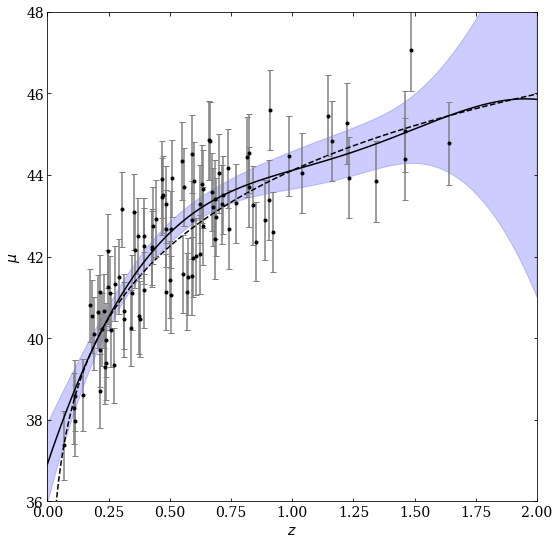

In [24]:
# Ivezic v2, Figure 8.11
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=False)

# ------------------------------------------------------------
# Generate data
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73, Tcmb0=0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0, cosmo=cosmo)

z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# ------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)
y_pred, sigma = gp.predict(z_fit[:, None], return_std=True)

# ------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()

N.B.  In this process we are assuming that the $x$ values are error free.  But really they will have error too.  Ivezic $\S$ 8.8 deals with this, but we are skipping it!